## Library

In [1]:
# # !pip install --upgrade
# !pip install numpy scikit-learn pandas yfinance tensorflow matplotlib
# !pip install tensorflow==2.12.0

In [2]:
# Data Preprocessing and Preparation
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


# Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import time

## Data preparation

In [3]:
df = yf.download('KBANK.BK', start="2019-07-01", end="2024-06-30")
df.index = pd.to_datetime(df.index)
df.columns = df.columns.droplevel(1)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2019-07-01 00:00:00+00:00,157.268036,188.5,191.0,188.5,189.5,6817000
2019-07-02 00:00:00+00:00,157.268036,188.5,189.5,188.0,188.5,3797000
2019-07-03 00:00:00+00:00,157.685181,189.0,189.5,188.0,188.5,3524300
2019-07-04 00:00:00+00:00,156.016556,187.0,190.0,187.0,189.0,7623900
2019-07-05 00:00:00+00:00,156.433731,187.5,188.0,187.0,187.0,2385300


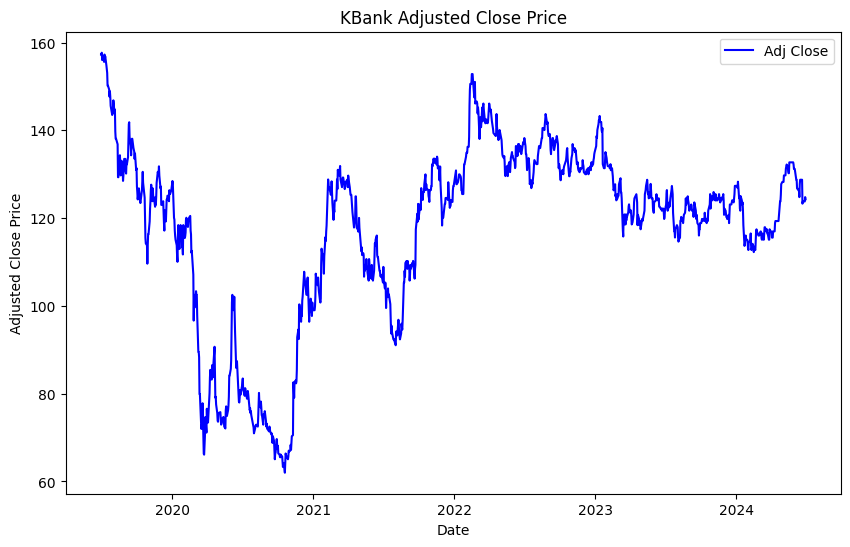

In [4]:
import matplotlib.pyplot as plt

# สมมติว่าคุณมี DataFrame ที่ชื่อว่า dataset ที่มีคอลัมน์ 'Adj Close' และ index เป็น datetime
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Adj Close'], label='Adj Close', color='blue')

# ตั้งชื่อกราฟ
plt.title('KBank Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')

# แสดง legend และ plot
plt.legend()
plt.show()


In [5]:
# function สำหรับ preprocess ข้อมูล time series หลายตัวแปร
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# เลือกข้อมูลหุ้นจาก list ของ DataFrame และ drop column 'Close' เนื่องจากเราจะใช้ column 'Adj. Close' เท่านั้น
df = df.drop('Close',axis=1)
dataset = df
values = dataset.values
values = values.astype('float32')


# ทำ scaling ข้อมูลด้วยวิธี min-max normalized scaling เปลี่ยน scale ข้อมูลแต่ละ column และเก็บค่า mean และ sd แต่ละ column ไว้สำหรับทำ rescale ข้อมูลภายหลัง
min_dict = dict()
max_dict = dict()
for col in dataset.columns:
  min_dict[col] = dataset[col].min()
  max_dict[col] = dataset[col].max()
  dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())


# ใช้ function สำหรับ preprocess ข้อมูลที่เขียนไว้ และ drop column ที่ไม่ได้ใช้
reframed = series_to_supervised(dataset.values, 15, 31,feat_name=df.columns)
# แก้ไขจากการ drop คอลัมน์ตั้งแต่ t ถึง t-6 เป็น t ถึง t-29
reframed.drop(['High(t+1)', 'High(t+2)', 'High(t+3)', 'High(t+4)', 'High(t+5)', 'High(t+6)', 'High(t+7)', \
               'High(t+8)', 'High(t+9)', 'High(t+10)', 'High(t+11)', 'High(t+12)', 'High(t+13)', 'High(t+14)', \
               'High(t+15)', 'High(t+16)', 'High(t+17)', 'High(t+18)', 'High(t+19)', 'High(t+20)', 'High(t+21)', \
               'High(t+22)', 'High(t+23)', 'High(t+24)', 'High(t+25)', 'High(t+26)', 'High(t+27)', 'High(t+28)', 'High(t+29)','High(t+30)',\
               'Low(t+1)', 'Low(t+2)', 'Low(t+3)', 'Low(t+4)', 'Low(t+5)', 'Low(t+6)', 'Low(t+7)', \
               'Low(t+8)', 'Low(t+9)', 'Low(t+10)', 'Low(t+11)', 'Low(t+12)', 'Low(t+13)', 'Low(t+14)', \
               'Low(t+15)', 'Low(t+16)', 'Low(t+17)', 'Low(t+18)', 'Low(t+19)', 'Low(t+20)', 'Low(t+21)', \
               'Low(t+22)', 'Low(t+23)', 'Low(t+24)', 'Low(t+25)', 'Low(t+26)', 'Low(t+27)', 'Low(t+28)', 'Low(t+29)','Low(t+30)',\
               'Open(t+1)', 'Open(t+2)', 'Open(t+3)', 'Open(t+4)', 'Open(t+5)', 'Open(t+6)', 'Open(t+7)', 
               'Open(t+8)', 'Open(t+9)', 'Open(t+10)', 'Open(t+11)', 'Open(t+12)', 'Open(t+13)', 'Open(t+14)', \
               'Open(t+15)', 'Open(t+16)', 'Open(t+17)', 'Open(t+18)', 'Open(t+19)', 'Open(t+20)', 'Open(t+21)', \
               'Open(t+22)', 'Open(t+23)', 'Open(t+24)', 'Open(t+25)', 'Open(t+26)', 'Open(t+27)', 'Open(t+28)', 'Open(t+29)','Open(t+30)',\
               'Volume(t+1)', 'Volume(t+2)', 'Volume(t+3)', 'Volume(t+4)', 'Volume(t+5)', 'Volume(t+6)', 'Volume(t+7)', \
               'Volume(t+8)', 'Volume(t+9)', 'Volume(t+10)', 'Volume(t+11)', 'Volume(t+12)', 'Volume(t+13)', 'Volume(t+14)', \
               'Volume(t+15)', 'Volume(t+16)', 'Volume(t+17)', 'Volume(t+18)', 'Volume(t+19)', 'Volume(t+20)', 'Volume(t+21)', \
               'Volume(t+22)', 'Volume(t+23)', 'Volume(t+24)', 'Volume(t+25)', 'Volume(t+26)', 'Volume(t+27)', 'Volume(t+28)', 'Volume(t+29)','Volume(t+30)'], axis=1, inplace=True)

In [6]:
reframed.head()

,Adj Close(t-15),High(t-15),Low(t-15),Open(t-15),Volume(t-15),Adj Close(t-14),High(t-14),Low(t-14),Open(t-14),Volume(t-14),...,Adj Close(t+21),Adj Close(t+22),Adj Close(t+23),Adj Close(t+24),Adj Close(t+25),Adj Close(t+26),Adj Close(t+27),Adj Close(t+28),Adj Close(t+29),Adj Close(t+30)
15,0.995641,1.000000,1.000000,1.000000,0.039494,0.995641,0.987288,0.995781,0.991507,0.021998,...,0.742789,0.720991,0.694834,0.707913,0.729710,0.747148,0.747148,0.716632,0.712272,0.738430
16,0.995641,0.987288,0.995781,0.991507,0.021998,1.000000,0.987288,0.995781,0.991507,0.020418,...,0.720991,0.694834,0.707913,0.729710,0.747148,0.747148,0.716632,0.712272,0.738430,0.734070
17,1.000000,0.987288,0.995781,0.991507,0.020418,0.982562,0.991525,0.987342,0.995754,0.044169,...,0.694834,0.707913,0.729710,0.747148,0.747148,0.716632,0.712272,0.738430,0.734070,0.751508
18,0.982562,0.991525,0.987342,0.995754,0.044169,0.986922,0.974576,0.987342,0.978769,0.013819,...,0.707913,0.729710,0.747148,0.747148,0.716632,0.712272,0.738430,0.734070,0.751508,0.795103
19,0.986922,0.974576,0.987342,0.978769,0.013819,0.982562,0.974576,0.978903,0.978769,0.025213,...,0.729710,0.747148,0.747148,0.716632,0.712272,0.738430,0.734070,0.751508,0.795103,0.830085


In [7]:
values = reframed.values

# Define the number of days for each set
# ทำ train, val, test split
values = reframed.values
n_train_percent = 0.7
n_val_percent = 0.15
train_split = int(values.shape[0] * n_train_percent)
val_split = int(values.shape[0] * (n_train_percent + n_val_percent))

train = values[:train_split, :]
val = values[train_split:val_split, :]
test = values[val_split:, :]

# เก็บค่า datetime ของ train, val, test
date_reframed = dataset.index[reframed.index]
date_train = date_reframed[:train_split]
date_val = date_reframed[train_split:val_split]
date_test = date_reframed[val_split:]

# split feature และ target
train_X, train_y = train[:, :-30], train[:, -30:]
val_X, val_y = val[:, :-30], val[:, -30:]
test_X, test_y = test[:, :-30], test[:, -30:]

# reshape input ให้เป็น 3D (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [8]:
# X (samples, timesteps, features)
# Y (samples , target)
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)
print(test_X.shape)
print(test_y.shape)

(816, 1, 80)
(816, 30)
(175, 1, 80)
(175, 30)
(175, 1, 80)
(175, 30)


## Create Model & Evaluate (ยังไม่ Hyperparameter tuning)


In [27]:
model = Sequential()

# LSTM 2 layer with ReLU activation
model.add(LSTM(units=70,activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(LSTM(units=70,activation='relu'))
model.add(Dropout(0.1))

# Output layer for 1 targets
model.add(Dense(1))

# Compile the model with  learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 70)             42280     
                                                                 
 dropout_2 (Dropout)         (None, 1, 70)             0         
                                                                 
 lstm_3 (LSTM)               (None, 70)                39480     
                                                                 
 dropout_3 (Dropout)         (None, 70)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 71        
                                                                 
Total params: 81,831
Trainable params: 81,831
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(val_X, val_y),callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])



Epoch 1/100
13/13 [==============================] - 3s 38ms/step - loss: 0.3486 - root_mean_squared_error: 0.4839 - val_loss: 0.2086 - val_root_mean_squared_error: 0.3249
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1545 - root_mean_squared_error: 0.2431 - val_loss: 0.0956 - val_root_mean_squared_error: 0.0994
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 0.1169 - root_mean_squared_error: 0.1961 - val_loss: 0.0974 - val_root_mean_squared_error: 0.1634
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0972 - root_mean_squared_error: 0.1781 - val_loss: 0.0679 - val_root_mean_squared_error: 0.0912
Epoch 5/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0864 - root_mean_squared_error: 0.1765 - val_loss: 0.0616 - val_root_mean_squared_error: 0.1056
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0758 - root_mean_squared_error: 0.1693 - val_loss: 0.0545 - val_root_

In [16]:
# คำนวณ predicted values
yhat_train = model.predict(train_X)
yhat_val = model.predict(val_X)
yhat_test = model.predict(test_X)


6/6 [==============================] - 0s 2ms/step


In [17]:
# คำนวณ residuals
resid_train = train_y - yhat_train
resid_val = val_y - yhat_val
resid_test = test_y - yhat_test

In [69]:
# # Reshape residuals for GRU input (samples, timesteps, features)
# resid_train = resid_train.reshape((resid_train.shape[0], 1, resid_train.shape[1]))
# resid_val = resid_val.reshape((resid_val.shape[0], 1, resid_val.shape[1]))
# resid_test = resid_test.reshape((resid_test.shape[0], 1, resid_test.shape[1]))

In [18]:
# เตรียมข้อมูล train สำหรับ residual GRU
train_X_resid = train_X.copy()
train_y_resid = resid_train.copy()
val_X_resid = val_X.copy()
val_y_resid = resid_val.copy()
test_X_resid = test_X.copy()
test_y_resid = resid_test.copy()

In [19]:
print(train_X_resid.shape)
print(train_y_resid.shape)
print(val_X_resid.shape)
print(val_y_resid.shape)
print(test_X_resid.shape)
print(test_y_resid.shape)

(816, 1, 80)
(816, 1)
(175, 1, 80)
(175, 1)
(175, 1, 80)
(175, 1)


In [20]:
# GRU model for predicting residuals
res_model = Sequential()
res_model.add(GRU(units=50, activation='relu', input_shape=(train_X_resid.shape[1], train_X_resid.shape[2]), return_sequences=True, kernel_regularizer=l2(0.001)))
res_model.add(Dropout(0.1))
res_model.add(GRU(units=50, activation='relu'))
res_model.add(Dropout(0.1))
res_model.add(Dense(1))

# Compile the GRU model
optimizer = Adam(learning_rate=0.001)
res_model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [21]:
# Train the GRU model
history_gru = res_model.fit(train_X_resid, train_y_resid, epochs=100, batch_size=64, validation_data=(val_X_resid, val_y_resid), 
                            callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/100
13/13 [==============================] - 3s 35ms/step - loss: 0.1095 - root_mean_squared_error: 0.1285 - val_loss: 0.0863 - val_root_mean_squared_error: 0.0654
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0894 - root_mean_squared_error: 0.1249 - val_loss: 0.0694 - val_root_mean_squared_error: 0.0694
Epoch 3/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0737 - root_mean_squared_error: 0.1254 - val_loss: 0.0541 - val_root_mean_squared_error: 0.0604
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0606 - root_mean_squared_error: 0.1241 - val_loss: 0.0441 - val_root_mean_squared_error: 0.0701
Epoch 5/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0503 - root_mean_squared_error: 0.1237 - val_loss: 0.0353 - val_root_mean_squared_error: 0.0704
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0422 - root_mean_squared_error: 0.1232 - val_loss: 0.0274 - val_root_

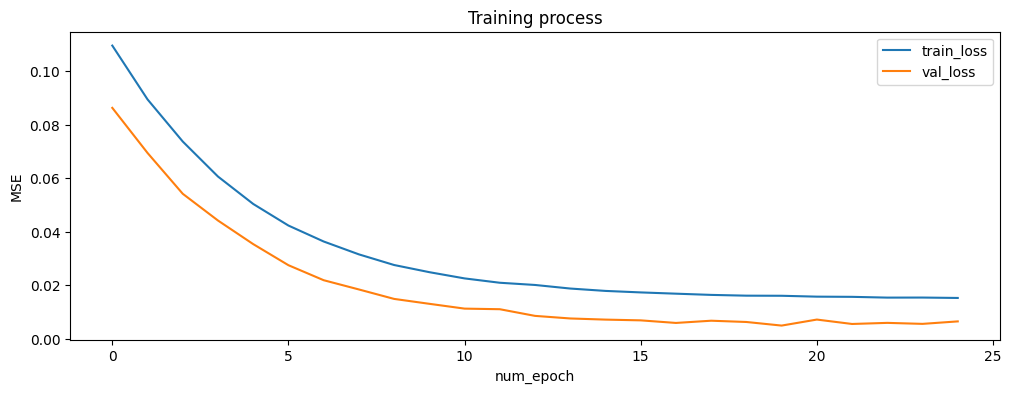

In [22]:
# พล็อตค่า train&test loss
plt.figure(figsize=(12, 4))
plt.plot(history_gru.history['loss'], label='train_loss')
plt.plot(history_gru.history['val_loss'], label='val_loss')
plt.legend(loc=1)
plt.xlabel('num_epoch')  # ตั้งชื่อแกน X เป็น num_epoch
plt.ylabel('MSE')        # ตั้งชื่อแกน Y เป็น MSE
plt.title('Training process')
plt.show()

In [23]:
results = model.evaluate(test_X, test_y)
print("Test Loss:", results[0])
print("Test RMSE:", results[1])

6/6 [==============================] - 0s 2ms/step - loss: 0.0094 - root_mean_squared_error: 0.0788
Test Loss: 0.009411069564521313
Test RMSE: 0.0788295716047287


In [24]:
# คำนวณ predicted residuals
yhat_train_resid = res_model.predict(train_X_resid)
yhat_val_resid = res_model.predict(val_X_resid)
yhat_test_resid = res_model.predict(test_X_resid)

6/6 [==============================] - 0s 2ms/step


In [25]:
# Final predicted value = LSTM predicted value + GRU predicted residuals
final_yhat_train = yhat_train + yhat_train_resid
final_yhat_val = yhat_val + yhat_val_resid
final_yhat_test = yhat_test + yhat_test_resid


In [26]:
# Reshape ข้อมูล (ถ้าจำเป็น)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Rescale ข้อมูลกลับ (ในกรณีใช้ Min-Max Normalization)
inv_yhat_train = final_yhat_train * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_yhat_val = final_yhat_val * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_yhat_test = final_yhat_test * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']

inv_y_train = train_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_y_val = val_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_y_test = test_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']


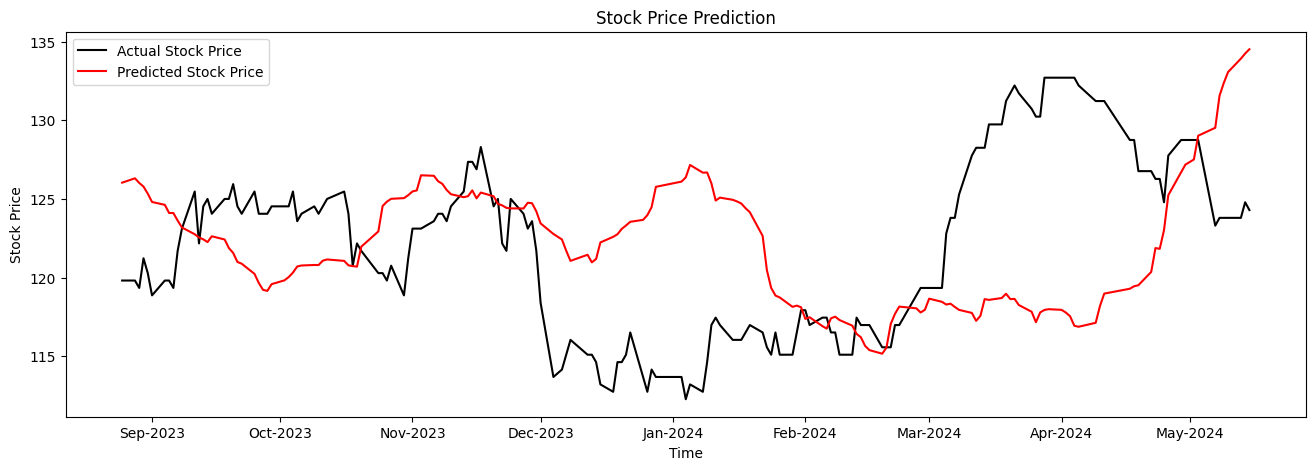

In [27]:
# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(16, 5))
plt.plot(date_test, inv_y_test[:, 0], color='black', label='Actual Stock Price')
plt.plot(date_test, inv_yhat_test[:, 0], color='red', label='Predicted Stock Price')

# ตั้งค่าช่วงเวลาบนแกน X ให้แสดงผลทุก 3 เดือน
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ตั้งค่าการแสดงผลของแกน X เป็นรูปแบบ 'Jan 2023', 'Feb 2023' เป็นต้น
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# ตั้งชื่อกราฟ
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

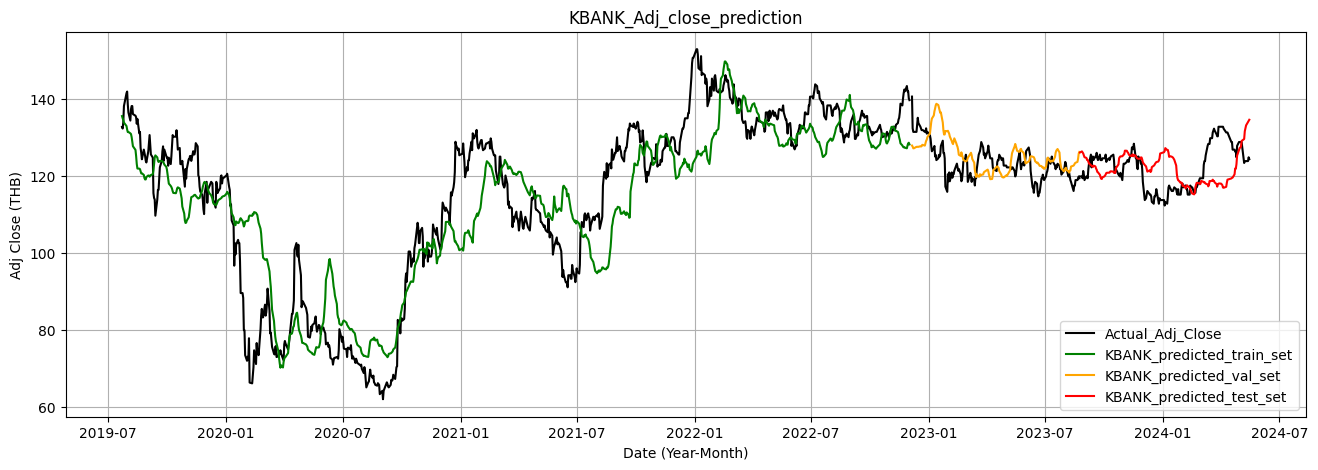

In [28]:
# Visualizing Results
plt.figure(figsize=(16, 5))

# Actual prices
plt.plot(date_train, inv_y_train[:, 0], color='black', label='Actual_Adj_Close')
plt.plot(date_val, inv_y_val[:, 0], color='black')
plt.plot(date_test, inv_y_test[:, 0], color='black')

# Predicted prices
plt.plot(date_train, inv_yhat_train[:, 0], color='green', label='predicted_train_set')
plt.plot(date_val, inv_yhat_val[:, 0], color='orange', label='predicted_val_set')
plt.plot(date_test, inv_yhat_test[:, 0], color='red', label='predicted_test_set')

# ตั้งค่าช่วงเวลาบนแกน X ให้แสดงผลทุก 6 เดือน
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# ตั้งค่าการแสดงผลของแกน X เป็นรูปแบบ 'Jan 2023', 'Feb 2023' เป็นต้น
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# ตั้งชื่อกราฟ
plt.title('KBANK_Adj_close_prediction')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Adj Close (THB)')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# คำนวณ MAPE และ RMSE
mape = mean_absolute_percentage_error(inv_y_test, inv_yhat_test)*100
rmse = np.sqrt(mean_squared_error(inv_y_test, inv_yhat_test))

# แสดงผลลัพธ์
print(f'MAPE: {mape:.4f}%')
print(f'RMSE: {rmse:.4f}')


MAPE: 4.5355%
RMSE: 7.0453


## Hyperparameter Tuning (Predicted Value)

In [9]:
def create_rnn_model(rnn_units_1, beta_1 ,LR,L2):
    model = Sequential()
    model.add(LSTM(rnn_units_1,activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False, kernel_regularizer=l2(L2)))
    model.add(Dropout(0.1))
    model.add(Dense(30))
    optimizer = Adam(learning_rate=LR, beta_1=beta_1, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

# Define the hyperparameters to tune lstm
param_dist_rnn = {
    'rnn_units_1': list(range(1, 101)),
    'LR': np.linspace(0.001, 0.1, 100).tolist(),
    'L2':[0.001,0.005,0.01,0.05,0.1],
    'beta_1':[0.7,0.8,0.9]
}

# Wrap the model into a KerasRegressor
rnn_model = KerasRegressor(build_fn=create_rnn_model, epochs=100, batch_size=64, verbose=0)

start_time = time.time()

# Define the RandomizedSearchCV object
rnn_random_search = RandomizedSearchCV(estimator=rnn_model, param_distributions=param_dist_rnn,
                                    n_iter=100, scoring='neg_root_mean_squared_error',
                                    cv=3, verbose=1, random_state=42, n_jobs=-1)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model using RandomizedSearchCV
rnn_random_search_result = rnn_random_search.fit(train_X, train_y, validation_data=(val_X, val_y), callbacks=[early_stopping])

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

/tmp/ipykernel_3895795/484836469.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  rnn_model = KerasRegressor(build_fn=create_rnn_model, epochs=100, batch_size=64, verbose=0)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


2024-12-19 13:20:09.791300: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 13:20:09.924952: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 13:20:09.930869: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 13:20:10.011889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 13:20:10.027820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 13:20:10.051123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 13:20:10.087094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 13:20:10.095994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-

Execution time: 2919.995228290558 seconds


In [10]:
# Get the best parameters and the best score
rnn_best_params = rnn_random_search_result.best_params_
rnn_best_score = -rnn_random_search_result.best_score_


In [11]:
print("Best Parameters:", rnn_best_params)
print("Best RMSE Score:", rnn_best_score)

Best Parameters: {'rnn_units_1': 95, 'beta_1': 0.9, 'LR': 0.038, 'L2': 0.001}
Best RMSE Score: 0.12005538205804962


## Hyperparameter Tuning (Predicted Residual)

In [12]:
rnn_model = create_rnn_model(rnn_units_1=95,beta_1=0.9 , LR=0.038, L2=0.001)
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 95)                66880     
                                                                 
 dropout_1 (Dropout)         (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                2880      
                                                                 
Total params: 69,760
Trainable params: 69,760
Non-trainable params: 0
_________________________________________________________________


2024-12-19 14:03:16.733208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 14:03:16.735113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 14:03:16.736384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [13]:
history = rnn_model.fit(train_X, train_y, epochs=150, batch_size=64, validation_data=(val_X, val_y),callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/150


2024-12-19 14:03:19.551513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 14:03:19.553785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 14:03:19.555261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/13 [=>............................] - ETA: 33s - loss: 0.5695 - root_mean_squared_error: 0.6609

2024-12-19 14:03:22.553503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 14:03:22.555640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 14:03:22.557229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 4s 67ms/step - loss: 0.2453 - root_mean_squared_error: 0.3299 - val_loss: 0.1371 - val_root_mean_squared_error: 0.1136
Epoch 2/150
13/13 [==============================] - 0s 10ms/step - loss: 0.1084 - root_mean_squared_error: 0.1725 - val_loss: 0.0439 - val_root_mean_squared_error: 0.0869
Epoch 3/150
13/13 [==============================] - 0s 11ms/step - loss: 0.0479 - root_mean_squared_error: 0.1632 - val_loss: 0.0510 - val_root_mean_squared_error: 0.2002
Epoch 4/150
13/13 [==============================] - 0s 11ms/step - loss: 0.0367 - root_mean_squared_error: 0.1630 - val_loss: 0.0127 - val_root_mean_squared_error: 0.0668
Epoch 5/150
13/13 [==============================] - 0s 10ms/step - loss: 0.0251 - root_mean_squared_error: 0.1388 - val_loss: 0.0128 - val_root_mean_squared_error: 0.0907
Epoch 6/150
13/13 [==============================] - 0s 9ms/step - loss: 0.0222 - root_mean_squared_error: 0.1354 - val_loss: 0.0126 - val_root_mean_squ

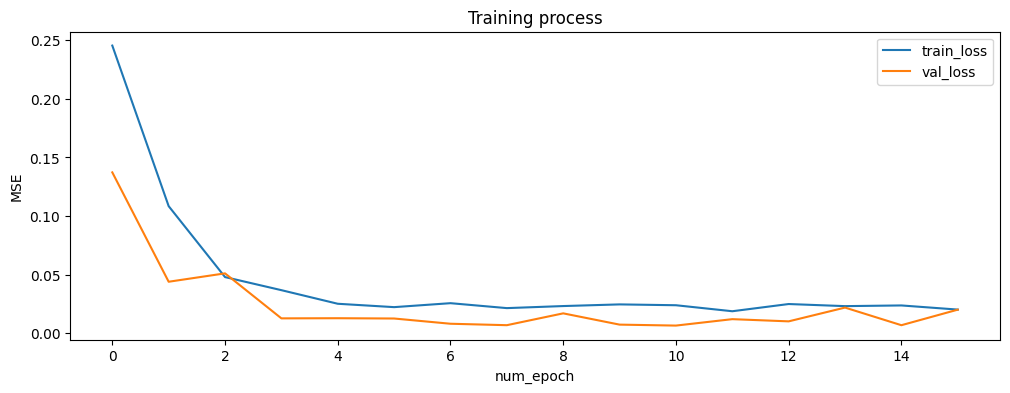

In [14]:
# พล็อตค่า train&test loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc=1)
plt.xlabel('num_epoch')  # ตั้งชื่อแกน X เป็น num_epoch
plt.ylabel('MSE')        # ตั้งชื่อแกน Y เป็น MSE
plt.title('Training process')
plt.show()

In [15]:
results = rnn_model.evaluate(test_X, test_y)
print("Test Loss:", results[0])
print("Test RMSE:", results[1])

6/6 [==============================] - 0s 2ms/step - loss: 0.0073 - root_mean_squared_error: 0.0633
Test Loss: 0.007276345510035753
Test RMSE: 0.0632617324590683


In [16]:
# คำนวณ predicted values
yhat_train = rnn_model.predict(train_X)
yhat_val = rnn_model.predict(val_X)
yhat_test = rnn_model.predict(test_X)


 1/26 [>.............................] - ETA: 32s

2024-12-19 14:03:50.637579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 14:03:50.639964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 14:03:50.641562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 2ms/step


In [17]:
# คำนวณ residuals
resid_train = train_y - yhat_train
resid_val = val_y - yhat_val
resid_test = test_y - yhat_test

In [18]:
# เตรียมข้อมูล train สำหรับ residual GRU
train_X_resid = train_X.copy()
train_y_resid = resid_train.copy()
val_X_resid = val_X.copy()
val_y_resid = resid_val.copy()
test_X_resid = test_X.copy()
test_y_resid = resid_test.copy()

In [19]:
print(train_X_resid.shape)
print(train_y_resid.shape)
print(val_X_resid.shape)
print(val_y_resid.shape)
print(test_X_resid.shape)
print(test_y_resid.shape)

(816, 1, 80)
(816, 30)
(175, 1, 80)
(175, 30)
(175, 1, 80)
(175, 30)


In [20]:
def create_gru_model(gru_units_1,beta_1,LR,L2):
    model = Sequential()
    model.add(GRU(gru_units_1,activation='tanh', input_shape=(train_X_resid.shape[1], train_X_resid.shape[2]), return_sequences=False, kernel_regularizer=l2(L2)))
    model.add(Dropout(0.1))
    model.add(Dense(30))
    optimizer = Adam(learning_rate=LR, beta_1=beta_1, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

# Define the hyperparameters to tune gru
param_dist_gru = {
    'gru_units_1': list(range(1, 101)),
    'LR': np.linspace(0.001, 0.1, 100).tolist(),
    'L2':[0.001,0.005,0.01,0.05,0.1],
    'beta_1':[0.7,0.8,0.9]
}

# Wrap the model into a KerasRegressor
gru_model = KerasRegressor(build_fn=create_gru_model, epochs=100, batch_size=64, verbose=0)

start_time = time.time()

gru_random_search = RandomizedSearchCV(estimator=gru_model, param_distributions=param_dist_gru,
                                    n_iter=100, scoring='neg_root_mean_squared_error',
                                    cv=3, verbose=1, random_state=42, n_jobs=-1)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model using RandomizedSearchCV
gru_random_search_result = gru_random_search.fit(train_X_resid, train_y_resid, validation_data=(val_X_resid, val_y_resid), callbacks=[early_stopping])

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/tmp/ipykernel_3895795/816457179.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_model = KerasRegressor(build_fn=create_gru_model, epochs=100, batch_size=64, verbose=0)
2024-12-19 14:27:03.478008: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 14:27:03.534285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 14:27:03.551902: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 14:27:03.559602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 14:27:03.568365: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-19 14:27:03.592275: W tensorflow/compiler/tf2t

Execution time: 2676.8005468845367 seconds


In [21]:
# Get the best parameters and the best score
gru_best_params = gru_random_search_result.best_params_
gru_best_score = -gru_random_search_result.best_score_


In [22]:
print("Best Parameters:", gru_best_params)
print("Best RMSE Score:", gru_best_score)

Best Parameters: {'gru_units_1': 91, 'beta_1': 0.9, 'LR': 0.013000000000000001, 'L2': 0.001}
Best RMSE Score: 0.11280427665490282


In [23]:
gru_model = create_gru_model(gru_units_1=91 ,beta_1=0.9 , LR=0.013, L2=0.001)
gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 91)                47229     
                                                                 
 dropout_3 (Dropout)         (None, 91)                0         
                                                                 
 dense_3 (Dense)             (None, 30)                2760      
                                                                 
Total params: 49,989
Trainable params: 49,989
Non-trainable params: 0
_________________________________________________________________


2024-12-19 14:51:18.613961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 14:51:18.615750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 14:51:18.616896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [24]:
history_resid = gru_model.fit(train_X_resid, train_y_resid, epochs=150, batch_size=64, validation_data=(val_X_resid, val_y_resid),callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/150


2024-12-19 14:51:21.488158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 14:51:21.490425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 14:51:21.492115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/13 [=>............................] - ETA: 24s - loss: 0.1763 - root_mean_squared_error: 0.2298

2024-12-19 14:51:24.156607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 14:51:24.158911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 14:51:24.160613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 3s 87ms/step - loss: 0.1121 - root_mean_squared_error: 0.1937 - val_loss: 0.0550 - val_root_mean_squared_error: 0.0774
Epoch 2/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0493 - root_mean_squared_error: 0.1214 - val_loss: 0.0232 - val_root_mean_squared_error: 0.0676
Epoch 3/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0259 - root_mean_squared_error: 0.1177 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0643
Epoch 4/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1184 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0766
Epoch 5/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0154 - root_mean_squared_error: 0.1142 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0563
Epoch 6/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0143 - root_mean_squared_error: 0.1132 - val_loss: 0.0052 - val_root_mean_squared

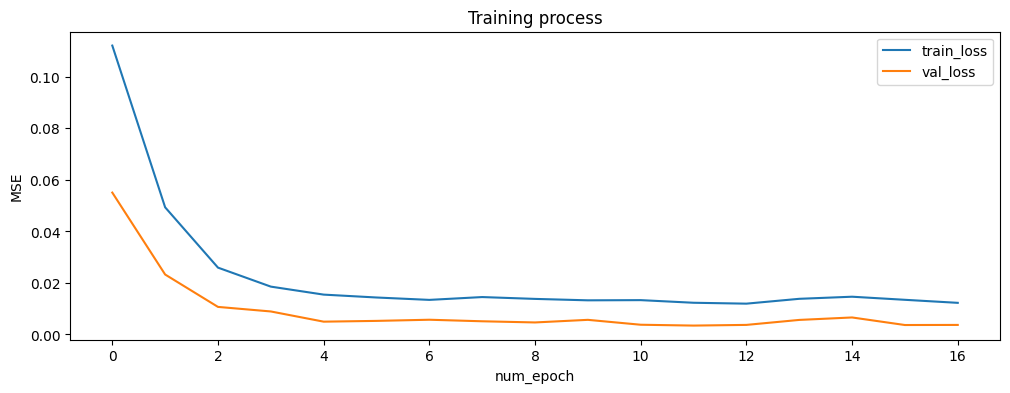

In [25]:
# พล็อตค่า train&test loss
plt.figure(figsize=(12, 4))
plt.plot(history_resid.history['loss'], label='train_loss')
plt.plot(history_resid.history['val_loss'], label='val_loss')
plt.legend(loc=1)
plt.xlabel('num_epoch')  # ตั้งชื่อแกน X เป็น num_epoch
plt.ylabel('MSE')        # ตั้งชื่อแกน Y เป็น MSE
plt.title('Training process')
plt.show()

In [26]:
results = gru_model.evaluate(test_X_resid, test_y_resid)
print("Test Loss:", results[0])
print("Test RMSE:", results[1])

6/6 [==============================] - 0s 2ms/step - loss: 0.0048 - root_mean_squared_error: 0.0639
Test Loss: 0.004771737847477198
Test RMSE: 0.06386606395244598


In [27]:
# คำนวณ predicted residuals
yhat_train_resid = gru_model.predict(train_X_resid)
yhat_val_resid = gru_model.predict(val_X_resid)
yhat_test_resid = gru_model.predict(test_X_resid)

26/26 [==============================] - 0s 1ms/step


2024-12-19 14:51:30.170675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-19 14:51:30.172791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-19 14:51:30.174337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 2ms/step


In [28]:
# Final predicted value = LSTM predicted value + GRU predicted residuals
final_yhat_train = yhat_train + yhat_train_resid
final_yhat_val = yhat_val + yhat_val_resid
final_yhat_test = yhat_test + yhat_test_resid


In [29]:
# Reshape ข้อมูล (ถ้าจำเป็น)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Rescale ข้อมูลกลับ (ในกรณีใช้ Min-Max Normalization)
inv_yhat_train = final_yhat_train * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_yhat_val = final_yhat_val * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_yhat_test = final_yhat_test * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']

inv_y_train = train_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_y_val = val_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_y_test = test_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']


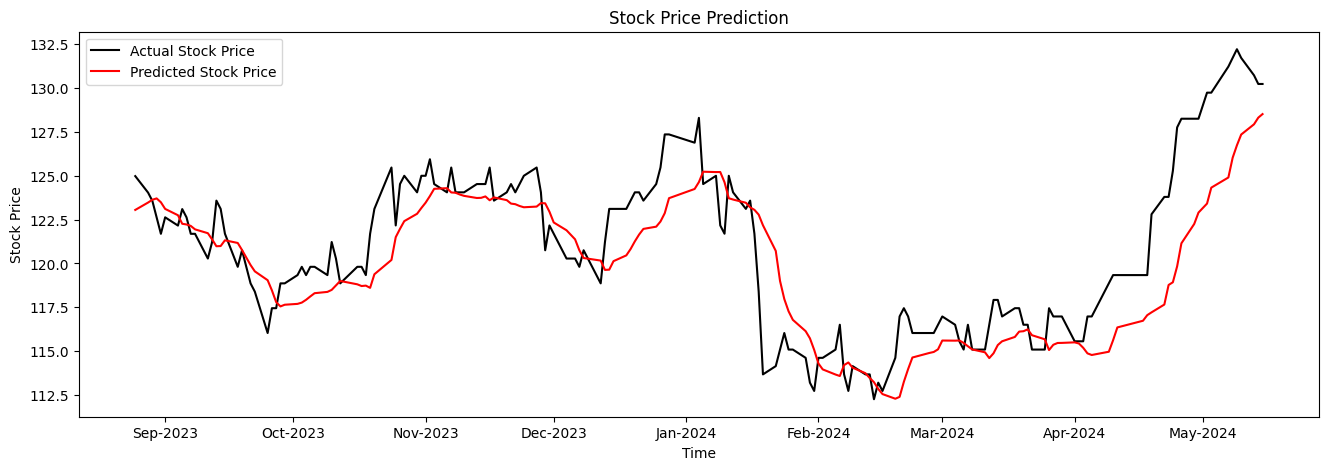

In [30]:
# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(16, 5))
plt.plot(date_test, inv_y_test[:, 0], color='black', label='Actual Stock Price')
plt.plot(date_test, inv_yhat_test[:, 0], color='red', label='Predicted Stock Price')

# ตั้งค่าช่วงเวลาบนแกน X ให้แสดงผลทุก 3 เดือน
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ตั้งค่าการแสดงผลของแกน X เป็นรูปแบบ 'Jan 2023', 'Feb 2023' เป็นต้น
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# ตั้งชื่อกราฟ
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

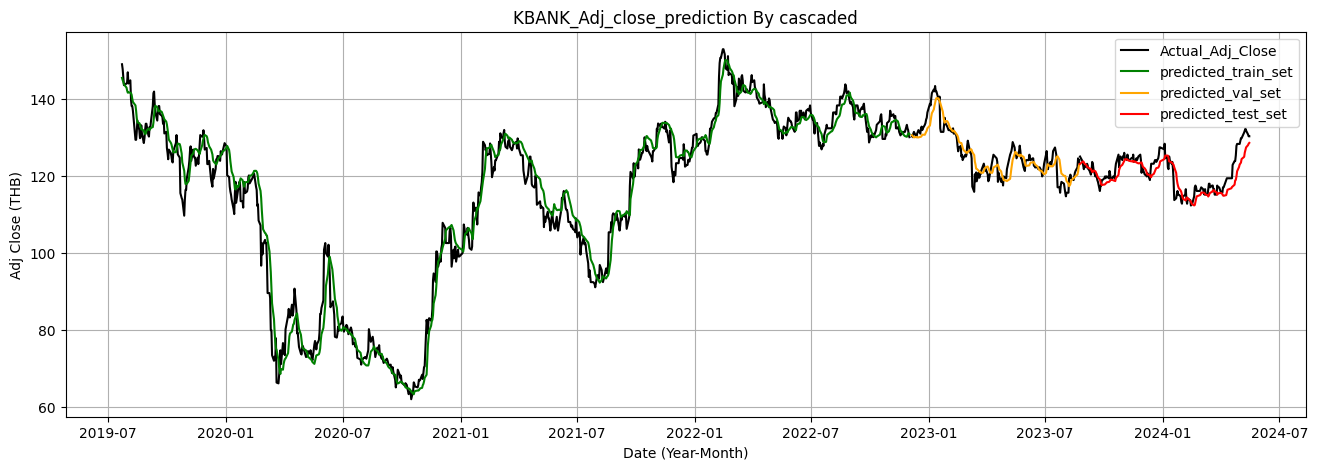

In [31]:
# Visualizing Results
plt.figure(figsize=(16, 5))

# Actual prices
plt.plot(date_train, inv_y_train[:, 0], color='black', label='Actual_Adj_Close')
plt.plot(date_val, inv_y_val[:, 0], color='black')
plt.plot(date_test, inv_y_test[:, 0], color='black')

# Predicted prices
plt.plot(date_train, inv_yhat_train[:, 0], color='green', label='predicted_train_set')
plt.plot(date_val, inv_yhat_val[:, 0], color='orange', label='predicted_val_set')
plt.plot(date_test, inv_yhat_test[:, 0], color='red', label='predicted_test_set')

# ตั้งค่าช่วงเวลาบนแกน X ให้แสดงผลทุก 6 เดือน
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# ตั้งค่าการแสดงผลของแกน X เป็นรูปแบบ 'Jan 2023', 'Feb 2023' เป็นต้น
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# ตั้งชื่อกราฟ
plt.title('KBANK_Adj_close_prediction By cascaded')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Adj Close (THB)')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# คำนวณ MAPE และ RMSE
mape = mean_absolute_percentage_error(inv_y_test, inv_yhat_test)*100
rmse = np.sqrt(mean_squared_error(inv_y_test, inv_yhat_test))

# แสดงผลลัพธ์
print(f'MAPE: {mape:.4f}%')
print(f'RMSE: {rmse:.4f}')


MAPE: 3.6764%
RMSE: 6.1113
